In [109]:
import os
import zipfile

from keras.src.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import applications, optimizers
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Flatten, Dense, Dropout
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop 
import pandas as pd
import matplotlib.pyplot as plt
import splitfolders
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras


1.0 Data extraction

In [2]:
zip_file_path = "/Users/godfreykrutzsch/Desktop/platesv2/plates.zip"
extract_to = "/Users/godfreykrutzsch/Desktop/platesv2/"

In [3]:

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)
    zip_ref.close()

2.0 Exploration

In [4]:
data_directory = "/Users/godfreykrutzsch/Desktop/platesv2/plates"
print(os.listdir(data_directory))

['.DS_Store', 'test', 'train']


3.0 Set directories 

In [5]:
# this directory mapping is required for splitting training and val and providing a reference to test data
training_directory = data_directory + "/train"
test_directory = data_directory + "/test"

4.0 Split training into Validation and Training (60:40)

In [6]:
splitfolders.ratio(training_directory, output="/Users/godfreykrutzsch/Desktop/platesv2/plates_split", ratio=(.6, .4))

Copying files: 40 files [00:00, 1148.86 files/s]


In [7]:
# these are required for image processing and loading
training_data_split = "/Users/godfreykrutzsch/Desktop/platesv2/plates_split/train/"
val_data_split = "/Users/godfreykrutzsch/Desktop/platesv2/plates_split/val/"

In [8]:
# check sub-directories 
print(f'visible in parent directory: {os.listdir("/Users/godfreykrutzsch/Desktop/platesv2/")}')
print(f'Classes for training data: {os.listdir(training_data_split)}')
print(f'Classes for validation data: {os.listdir(val_data_split)}')

visible in parent directory: ['standard-setup-learn-rate.csv', 'patience-10.csv', 'freezemodel.csv', 'freezemodel-again-again.csv', 'new_baseline-steps50.csv', 'standard-setup-learn-rate0001.csv', '.DS_Store', 'patience-15.csv', 'plates_split', 'new_baseline-steps150.csv', 'plusvalidation_early_stop.csv', 'freezemodel-again.csv', 'patience-10-0.csv', '__MACOSX', 'new_baseline.csv', 'restart.csv', 'plates.zip', 'plates', 'plusvalidation.csv', 'new_baseline-steps100.csv', 'freezemodel-again-again-gradual.csv', 'sample_submission.csv']
Classes for training data: ['cleaned', 'dirty']
Classes for validation data: ['cleaned', 'dirty']


5.0 set global variables for image and batch sizes

In [9]:
# width & height images
image_size = 224
# the number of images in each batch during training (hyper-parameter)
batch_size = 32

5.0 Image preprocessing and loading

In [10]:
# this function generate batches of tensor image data with real time augmentation, it creates variations of images on the fly.

train_datagen = ImageDataGenerator(
        rotation_range=40,      # randomly rotate image up to 40 degrees 
        width_shift_range=0.2,  # randomly shift image horizontally by 20% of the width
        height_shift_range=0.2, # randomly shift image vertically by 20% of the height
        shear_range=0.2,        # randomly apply shear transformation
        zoom_range=0.2,         # randomly zoom into image
        horizontal_flip=True,   # randomly flip image horizontally 
        vertical_flip=True      # randomly flip image vertically
)

train_generator = train_datagen.flow_from_directory(
        #training_directory,
        training_data_split,
        target_size=(image_size,image_size),
        batch_size=batch_size,
        class_mode='binary'
)

# create data generator for validation

val_datagen = ImageDataGenerator(
        rotation_range=40,      # randomly rotate image up to 40 degrees 
        width_shift_range=0.2,  # randomly shift image horizontally by 20% of the width
        height_shift_range=0.2, # randomly shift image vertically by 20% of the height
        shear_range=0.2,        # randomly apply shear transformation
        zoom_range=0.2,         # randomly zoom into image
        horizontal_flip=True,   # randomly flip image horizontally 
        vertical_flip=True    
)

validation_generator = val_datagen.flow_from_directory(
        val_data_split,
        target_size=(image_size,image_size),
        batch_size=batch_size,
        class_mode='binary'
)

# we have enough test data so we will not make more
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
        data_directory,
        classes=['test'],
        target_size=(image_size, image_size),
        batch_size=1,
)

Found 24 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 744 images belonging to 1 classes.


6.0 Loading pre-trained model: infrastructure part 1

In [112]:
# this model is form big data with complex data - i have just 40 images :=)
# base_model = applications.InceptionResNetV2(weights='imagenet', include_top=False,
                                           # input_shape=(image_size,image_size, 3))

In [113]:
base_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=(image_size,image_size,3))

In [114]:
# ensure pre-learned features are preserved by freezing the models base layers (the layers where it is pretrained as we do not want to overwrite these nor change in training! ((I just changed to True for fine tuning)
base_model.trainable = False

7.0 Infrastructure CNN part 2

7.1 Add new custom layers on top of frozen base_model

In [118]:
# extract pre-train InceptionRNV2 output, which is the input to the following custom layers
x = base_model.output

In [119]:
#converts the 2D matrix output of model to 1D vector. Why? it must be done before feeding the data into THE fully connected layer (Dense). This is mored detailed but has a large number of parameters not great for a small data set.
# x = Flatten()(x)

In [120]:
# trade of between falttern and Global: Global is better for small datasets and can reduce overfitting e.g. compress feature maps into smaller vectors.
x = GlobalAveragePooling2D()(x)

In [121]:
# adds a fully connected layer (densely connected layer). this layer is used to learn complex patterns from the flatten feature map and specifies the number of neurons (1024)
x = Dense(1024, activation='relu')(x)

In [122]:
# this is a regularization technique to prevent overfitting by dropping a fraction of neurons during each training iteration.
x = Dropout(0.5)(x)

7.2 Final Prediction Layer

In [123]:
# this defines a fully connected layer with 1 output neuron. The sigmoid function  squash value to between 0 and 1 typical for classification tasks, where output represents that a given input belongs to a class e.g dirt plate.
prediction = Dense(1, activation='sigmoid')(x)

# note in dense layer activation is always sigmoid if you are have two classes (binary class e.g. clean or dirty), for multi-class classification we use softmax in dense layer.

7.3 Model definition

In [124]:
# this create a keras model object which takes the input of the pre-trained base model (e.g. InceptionResNetv2) and outputs the final prediction layer. the prediction is the output layer of the entire model, which predicts if image is clean or dirty plate
model = Model(inputs=base_model.input, outputs=prediction)

8.0 Compile model

In [125]:
# this is a classification problem ´binary crossentropy´ is used as loss function(difference between predicted probabilities and actual.
# RMSprop is a optimizer for training neural networks
# lr=0.0001 inital learning rate (hyper parameter)
# metrics accuracy means model will track accuracy during training.
model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=0.0001, decay=1e-6), metrics=['accuracy'])

/opt/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


9.0 Early stopping

In [126]:
# this helps to STOP training at the RIGHT time to avoid OVERFITTING
# training will monitor validation loss (or val_accuracy) if selected.
# if validation does not improve for 5 epochs it will stop
# restore best weights after stopping the model will restore the best weights from best performing epochs
# for accuracy (val_acc) we set mode to max e.g. the higher the accuracy the better. if we set monitor to loss(val_loss) then mode = min as we would want to minimise loss.
# verbose 1 give  information if stop early and where
early_stopping = EarlyStopping(monitor='val_loss', mode='min',patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)


10.0 Training

In [127]:
# train model with history object
history = model.fit(
        train_generator, 
        validation_data=validation_generator,
        #ensures imageDataGenerator can generate enough batches for each epoch
        steps_per_epoch=100,    
        epochs=100,              # hyper-parameter
        verbose=1,  
        callbacks=[early_stopping, reduce_lr]# show progress bar
        )

Epoch 1/100
  1/100 ━━━━━━━━━━━━━━━━━━━━ 6:42 4s/step - accuracy: 0.6250 - loss: 0.7031

/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6250 - loss: 0.7031 - val_accuracy: 0.3750 - val_loss: 0.8156 - learning_rate: 1.0000e-04
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6667 - loss: 0.6105 - val_accuracy: 0.5625 - val_loss: 0.8418 - learning_rate: 1.0000e-04
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5833 - loss: 0.6696 - val_accuracy: 0.3125 - val_loss: 0.8478 - learning_rate: 1.0000e-04
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8333 - loss: 0.4569 - val_accuracy: 0.5000 - val_loss: 0.8315 - learning_rate: 1.0000e-04
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6667 - loss: 0.4277 - val_accuracy: 0.3750 - val_loss: 0.9299 - learning_rate: 1.0000e-04
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9583 - loss: 0.2494 - val_accuracy: 0.5625 - val_loss: 1.0016 - learning_rate: 1.0000e-04
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.91

12 Continue training

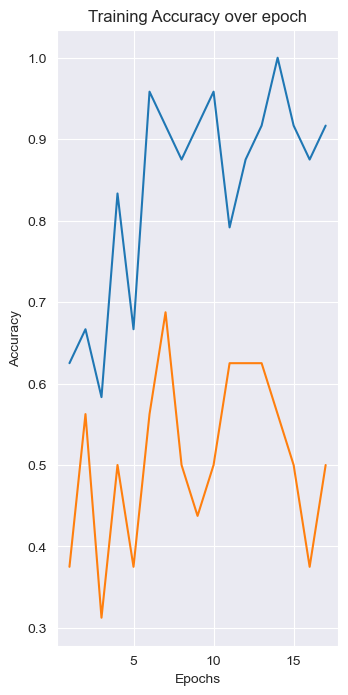

In [128]:
# access the accuracy and loss from history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#Generate the range of epochs
epochs_range = range(1, len(acc)+1)

# plot the accuracy
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy over epoch")
plt.show()

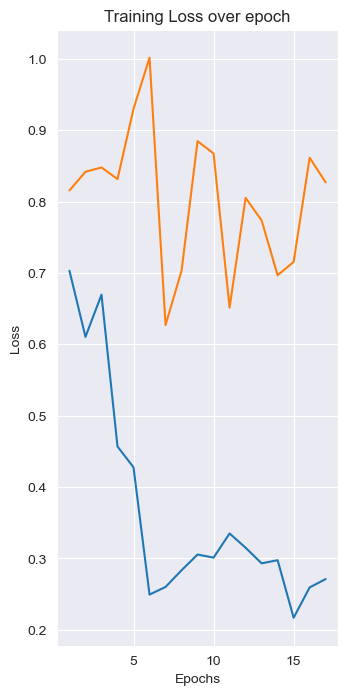

In [129]:
# plot the loss
plt.figure(figsize=(8,8))
plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss over epoch")
plt.show()

10 Prediction

In [130]:
test_generator.reset()
predict = model.predict(test_generator, steps = len(test_generator.filenames))
len(predict)

744/744 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step


744

In [131]:
predict[:5]

array([[0.15011808],
       [0.8105668 ],
       [0.8843737 ],
       [0.93647647],
       [0.29414496]], dtype=float32)

In [132]:
sub_df = pd.read_csv('/Users/godfreykrutzsch/Desktop/platesv2/sample_submission.csv')
sub_df.head()

,id,label
0,0,dirty
1,1,dirty
2,2,dirty
3,3,dirty
4,4,dirty


In [133]:
sub_df.label.value_counts()

label
dirty    744
Name: count, dtype: int64

In [134]:
sub_df['label'] = predict
sub_df['label'] = sub_df['label'].apply(lambda x : 'dirty' if x > 0.5 else 'cleaned')
sub_df.head()

,id,label
0,0,cleaned
1,1,dirty
2,2,dirty
3,3,dirty
4,4,cleaned


In [135]:
sub_df.label.value_counts()

label
dirty      716
cleaned     28
Name: count, dtype: int64

In [136]:
sub_df.to_csv('/Users/godfreykrutzsch/Desktop/platesv2/useResNet50andGlobal.csv', index=False)